# Least-Squares Background Fitting
We attempt to fit a range of polynomial functions to the background using a linear least-squares fitting routine as implemented by SciPy. This is a binned fitting routine. Optimised parameters are retained in this notebook and in the more general data directory.

In [2]:
import numpy as np
from scipy.optimize import curve_fit
import pandas as pd
import matplotlib.pyplot as plt
import mplhep as hep
plt.style.use([hep.style.ROOT, hep.style.firamath])

## Fetch Mass Distribution
We need to construct an actual background mass distribution to fit from. We will use the background data as given in the real tuple and restrict the sidebands to the values the neural network is currently using. We will also want to try the optimisation using a variety of bin widths.

In [3]:
df = pd.read_csv('../data_files/9.1.4/all.csv', index_col=[0])
# 9.1.4 : Pre + (mass restrict +- 600 MeV)
df = df[df['category'] == 0]
df = df[df['IsSimulated'] == False]
df.head()

,JPs_FD_ORIVX,LStar_ORIVX_CHI2,Lb_ENDVERTEX_CHI2,LN_Lb_IPCHI2_OWNPV,Lb_PT,LN_Lb_MINIPCHI2,LN_Lb_IP01,LN_Lb_IP23,LN_Lb_IP_OWNPV,p_TRACK_VeloCHI2NDOF,...,JPs_IP_TOPPV,LStar_IP_ORIVX,JPs_IP_ORIVX,LN_SUM_CONEISO,LN_SUM_IPCHI2,LN_COS_THETA,LN_COS_LBDIRA,Lb_M,IsSimulated,category
0,0.484038,1.629828,1.629828,2.705390,5784.779630,2.705390,0.051043,-1.618633,-2.785129,0.258359,...,0.198220,0.010331,0.007463,-1.086965,6.527298,-6.054074,-0.777226,6345.360195,False,0
1,0.091063,28.351055,28.351055,0.462827,14080.746462,0.462827,-0.102404,-2.211085,-4.035469,0.683810,...,0.109607,0.066393,0.000706,-1.065188,5.274609,-4.810993,-0.777189,6039.345660,False,0
2,0.841387,22.296505,22.296505,0.410669,14432.943611,0.410669,-2.379339,-1.066316,-4.181809,0.438744,...,0.344258,0.017507,0.057614,-0.122136,7.035033,-5.366926,-0.777187,4731.626993,False,0
3,1.465618,5.756594,5.756594,3.198752,6061.485136,3.198752,-1.448551,-1.833423,-2.110772,0.712991,...,0.159840,0.043450,0.049073,-0.342112,5.353749,-7.864340,-0.777303,6106.264652,False,0
4,0.411388,31.774448,31.774448,2.975749,2233.814727,2.975749,-0.421157,-1.116130,-2.523012,1.378098,...,0.327540,0.124324,0.016389,-1.721648,7.041729,-7.433966,-0.777260,4867.267611,False,0


In [4]:
df2 = pd.read_csv('../data_files/9.1.1/all.csv', index_col=[0])
# 9.1.1 : mass restrict +- 600 MeV
df2 = df2[df2['category'] == 0]
df2 = df2[df2['IsSimulated'] == False]

## Bin the Distribution
Now that we have a dataframe with all the background events we care about it is now prudent to fit our background functions to this. Before doing this these data should be put into bins. The value of bins is variable and will affect the final fit. For this reason we choose the finest bin structure possible.

In [5]:
m1 = df['Lb_M'].to_numpy()
m2 = df2['Lb_M'].to_numpy()
# Only keep background events

## Visual Analysis
The best way to get a feel for these data is to do an initial visual analysis. We can do this by plotting the mass distribution and seeing what sort of shape it seems to take. We might normally expect a combinatorial background to be exponentially decaying excluding any resonances.

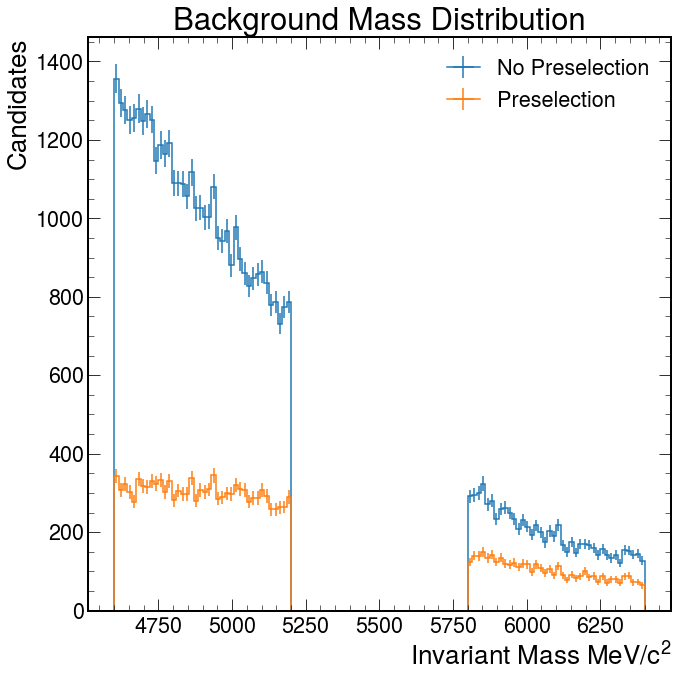

In [6]:
bins = np.concatenate([np.linspace(4600, 5200, 41), np.linspace(5800, 6400, 41)])

h1, _ = np.histogram(m1, bins=bins)
h2, _ = np.histogram(m2, bins=bins)

fig, ax = plt.subplots(1, 1)
ax.set_title(f"Background Mass Distribution")
hep.histplot([h2, h1], bins, ax=ax, yerr=True, label=['No Preselection', 'Preselection'])
#ax.hist(df['Lb_M'], bins=blocks, label='Bayesian Blocks', histtype='step')
plt.ylabel('Candidates', horizontalalignment='right', y=1.0)
plt.xlabel(r'Invariant Mass MeV$/c^2$', horizontalalignment='right', x=1.0)
ax.legend()
plt.tight_layout()
plt.savefig('../images/BackgroundFits/Mass_Distribution.png', dpi=800)
plt.show()

## Fitting Polynomials

In [7]:
bin_width = bins[1]-bins[0]
func_x = np.linspace(4600-5500, 6400-5500, 500)

# Find the scatter position of all the bin/frequency pairs
bin_centres = np.array([np.mean(bins[i:i+2]) for i in range(len(bins)-1)])-5500
bin_centres = np.delete(bin_centres, 40) # Remove the rogue middle bin
h1n = np.array([i for i in h1 if i > 0])

In [39]:
def linear(x, a, b):
    return a*x + b

def exp_decay(x, a, b, c):
    return np.exp(-(a*(x-b))) + c

def logarithm(x, a, b, c):
    return -b*np.log(x-a) + c

def quadratic(x, a, b, c):
    return a*x**2 + b*x + c

def cubic(x, a, b, c, d):
    return a*x**3 + b*x**2 + c*x + d

In [40]:
popt1, pcov1 = curve_fit(linear, bin_centres, h1n, [-0.15, 200], np.sqrt(h1n), absolute_sigma=True)
popt2, pcov2 = curve_fit(cubic, bin_centres, h1n, [1, 1, 1, 1], np.sqrt(h1n), absolute_sigma=True)

In [41]:
err = np.sqrt(np.diag(pcov2))

#lcubic = cubic(func_x, popt2[0]-err[0], popt2[1]-err[1], popt2[2]-err[2], popt2[3]-err[3])
#hcubic = cubic(func_x, popt2[0]+err[0], popt2[1]+err[1], popt2[2]+err[2], popt2[3]+err[3])

In [42]:
popt2

array([ 9.25454622e-08, -1.95491716e-05, -2.08072140e-01,  2.08896705e+02])

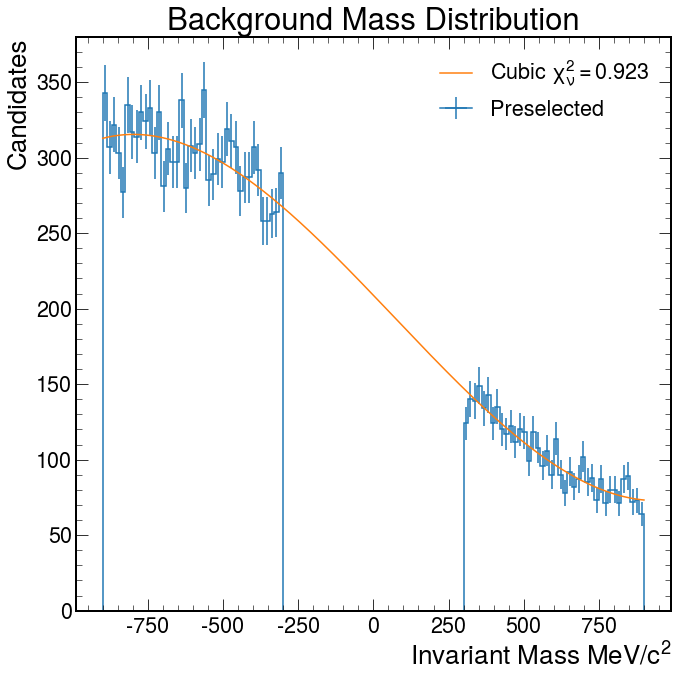

In [43]:
fig, ax = plt.subplots(1, 1)
ax.set_title(f"Background Mass Distribution")
hep.histplot(h1, bins=(bins-5500), ax=ax, yerr=True, label='Preselected')
#ax.scatter(bin_centres, h1n, label='Scatter')
#ax.plot(func_x, linear(func_x, *popt1), label='Linear')
ax.plot(func_x, cubic(func_x, *popt2), label=r'Cubic $\chi^2_{\nu}=0.923$')
#ax.fill_between(func_x, lcubic, hcubic, alpha=0.4, color='orange', linewidth=0, label=r'$1\sigma$')
plt.ylabel('Candidates', horizontalalignment='right', y=1.0)
plt.xlabel(r'Invariant Mass MeV$/c^2$', horizontalalignment='right', x=1.0)
ax.legend()
ax.set_ylim(0, 380)
plt.tight_layout()
#plt.savefig('../images/BackgroundFits/Preselected_Cubic_Fit.png', dpi=800)
plt.show()

In [44]:
for j, i in enumerate(popt2):
    print(f"Value: {i} +- {err[j]}")

Value: 9.254546221042552e-08 +- 1.239558513524568e-08
Value: -1.954917162621531e-05 +- 7.540192312802521e-06
Value: -0.20807214015665842 +- 0.006750097880315321
Value: 208.8967046045883 +- 3.36945754981659


In [37]:
from scipy.stats import ks_2samp

ks_2samp(cubic(bin_centres, *popt2), h1n)

KstestResult(statistic=0.1375, pvalue=0.4382622708472999)

In [38]:
chisq = np.sum((h1n-cubic(bin_centres, *popt2))**2/h1n)
chisq/(len(h1n)-4)

0.9232692383270654

## ROOT Fitting

In [14]:
from ROOT import TH1F, TF1

Welcome to JupyROOT 6.24/06


In [15]:
h = TH1F('h', 'Mass Distribution', len(h1n), -900, 900)
for i, j in enumerate(h1n):
    h.SetBinContent(i+1, j)

In [16]:
g1 = TF1('g1', 'pol3', -900, 900)
h.Fit(g1, 'R')
par1 = g1.GetParameters()


****************************************
Minimizer is Linear / Migrad
Chi2                      =      318.893
NDf                       =           76
p0                        =      198.291   +/-   2.34904     
p1                        =    -0.280905   +/-   0.00705296  
p2                        = -4.72577e-07   +/-   6.45625e-06 
p3                        =  2.02919e-07   +/-   1.31882e-08 


Info in <TCanvas::MakeDefCanvas>:  created default TCanvas with name c1


In [18]:
def f(x, p0, p1, p2, p3):
    return p0 + p1*x + p2*x**2 + p3*x**3

def f2(x, p0, p1, p2):
    return p0 + p1*x + p2*x**2

In [17]:
params = [par1[0], par1[1], par1[2], par1[3]]

In [19]:
np.sum((h1n-f(bin_centres, *params))**2/h1n)

270.5316723825202

In [1]:
fig, ax = plt.subplots(1, 1)
ax.set_title(f"Background Mass Distribution")
hep.histplot(h1, bins=(bins-5500), ax=ax, yerr=True, label='Preselected')
ax.plot(func_x, f(func_x, *params))
#ax.scatter(bin_centres, h1n, label='Scatter')
#ax.plot(func_x, linear(func_x, *popt1), label='Linear')
#ax.plot(func_x, cubic(func_x, *popt2), label=r'Cubic $\chi^2_{\nu}=0.936$')
#ax.fill_between(func_x, l3cubic, h3cubic, alpha=0.2, color='red', linewidth=0, label=r'$3\sigma$')
#ax.fill_between(func_x, lcubic, hcubic, alpha=0.4, color='orange', linewidth=0, label=r'$1\sigma$')
plt.ylabel('Candidates', horizontalalignment='right', y=1.0)
plt.xlabel(r'Invariant Mass MeV$/c^2$', horizontalalignment='right', x=1.0)
ax.legend()
ax.set_ylim(0, 380)
plt.tight_layout()
plt.show()

NameError: name 'plt' is not defined